# Titanic Analysis

### Initialize the Kaggle API 

In [69]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

competition_name = "titanic"
download_path = os.getcwd()  # Folder where the dataset will be saved

# Download the competition files
api.competition_download_files(competition_name, path=download_path)

# # Path of downloaded ZIP file
zip_path = os.path.join(download_path, f"{competition_name}.zip")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_path)
os.remove(zip_path)  # Remove the ZIP file after extraction

### Import library

We'll start by importing the necessary libraries and then configure the notebook to read the data into a DataFrame.

In [70]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import csv

### Data Acquisition

Loading the `train.csv` and `test.csv` bases for analysis. Let's take a first look at our Dataframe.

In [71]:
# Load the datasets
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary/Variable Notes

[Titanic Data](https://github.com/maylonleoncio/titanic/blob/main/train.csv)  - Contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic.

<style>
  table {
    margin: auto;
    width: 50%;
    border-collapse: collapse; /* Para unir as bordas das células */
  }
  th, td {
    text-align: justify;
    padding: 8px;
    border: 1px solid black; /* Adiciona uma borda de 1px com cor cinza (#ddd) */
  }
</style>

<table>
    <tr>
        <th> Variable </th>
        <th> Definition </th>
        <th> Key </th> 
    </tr>
    <tr>
        <td>survival</td>
        <td>Survival</td>
        <td>0 = No, 1 = Yes</td>
    </tr>
    <tr>		
        <td>Pclass</td>
        <td>Ticket class</td>
        <td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
    </tr>
    <tr>		
        <td>sex</td>
        <td>Sex</td>
        <td></td>
    </tr>
    <tr>		
        <td>Age</td>
        <td>Age in years</td>
        <td></td>
    </tr>
    <tr>		
        <td>sibsp</td>
        <td># of siblings / spouses aboard the Titanic</td>
        <td></td>
    </tr>
    <tr>		
        <td>parch</td>
        <td># of parents / children aboard the Titanic</td>
        <td></td>
    </tr>
    <tr>		
        <td>ticket</td>
        <td>Ticket number</td>
        <td></td>
    </tr>
    <tr>		
        <td>fare</td>
        <td>Passenger fare</td>
        <td></td>
    </tr>
    <tr>		
        <td>cabin</td>
        <td>Cabin number</td>
        <td></td>
    </tr>
    <tr>		
        <td>embarked</td>
        <td>Port of Embarkation</td>
        <td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
    </tr>


</table>

**Pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**Age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**Sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Data cleaning

Before we begin the exploratory data analysis, we will perform a thorough cleaning of the database. **Data cleaning** is a crucial step in data analysis as it involves the __identification and removal of any missing, duplicated, or irrelevant data__. The goal is to ensure that the data is accurate, consistent, and error-free, as incorrect or inconsistent data can negatively impact the performance of Machine Learning models

In [72]:
# Check the data information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We observe that there are missing values at the Age, Cabin and Embarked columns.

In [73]:
cat_col = []
num_col = []

for col in train.columns:
    if train[col].dtype == 'object':
        cat_col.append(col)
    else:
        num_col.append(col)
print('Check the Categorical and Numerical Columns:')
print('Categorical columns: ', cat_col)
print('Numerical columns: ', num_col)

Check the Categorical and Numerical Columns:
Categorical columns:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical columns:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [74]:
# Check the duplicate rows
train.duplicated().value_counts()

False    891
Name: count, dtype: int64

Note that there is no duplication of lines at the base.

In [75]:
print('Checking the total row count, the quantity of unique values, the number of nulls, and the percentage of nulls in each column.')
print()

print(pd.DataFrame({'Counts': train.count(), 'Counts unique': train.nunique(),'Counts NA': train.isnull().sum(),'Percentages (%) NA':  round(train.isnull().sum()/train.shape[0]*100,2)}))

Checking the total row count, the quantity of unique values, the number of nulls, and the percentage of nulls in each column.

             Counts  Counts unique  Counts NA  Percentages (%) NA
PassengerId     891            891          0                0.00
Survived        891              2          0                0.00
Pclass          891              3          0                0.00
Name            891            891          0                0.00
Sex             891              2          0                0.00
Age             714             88        177               19.87
SibSp           891              7          0                0.00
Parch           891              7          0                0.00
Ticket          891            681          0                0.00
Fare            891            248          0                0.00
Cabin           204            147        687               77.10
Embarked        889              3          2                0.22


It is noted that there are missing values in three variables. The ``Age`` column has 177 rows (**19.87%** of the total) without information, the ``Cabin`` variable has 687 rows (**77.1%** of the total), indicating that more than half of the data is missing, and in the ``Embarked`` column, out of a total of 891 rows, only 2 (**0.22%** of the total) are without information. We will have to decide whether to omit these variables or impute them with some values when we model relationships based on ``Age`` or ``Cabin`` or ``Embarked``.

##### Removal of all unwanted observations
Includes deleting duplicate/redundant or irrelevant values from the dataset.

In [76]:
# Removal of all unwanted observations
train = train.drop(columns=['Name'])
test = test.drop(columns=['Name'])
train.shape

(891, 11)

##### Missing data processing

Imputing missing values from past observations. As we can see from the previous result, Cabin has 77% missing values, Age has 19.87%, and Embarked has 0.22% missing values. It's not a good idea to fill 77% of missing values. For now, we will not drop the Cabin column yet because we will use it in the __feature engineering process__. The Embarked column has only 0.22% missing values, so we will drop the rows with null values in the Embarked column.

In [77]:
train.dropna(subset=['Embarked'], axis=0, inplace=True)
train.shape

(889, 11)

##### Imputing the missing values from observations.

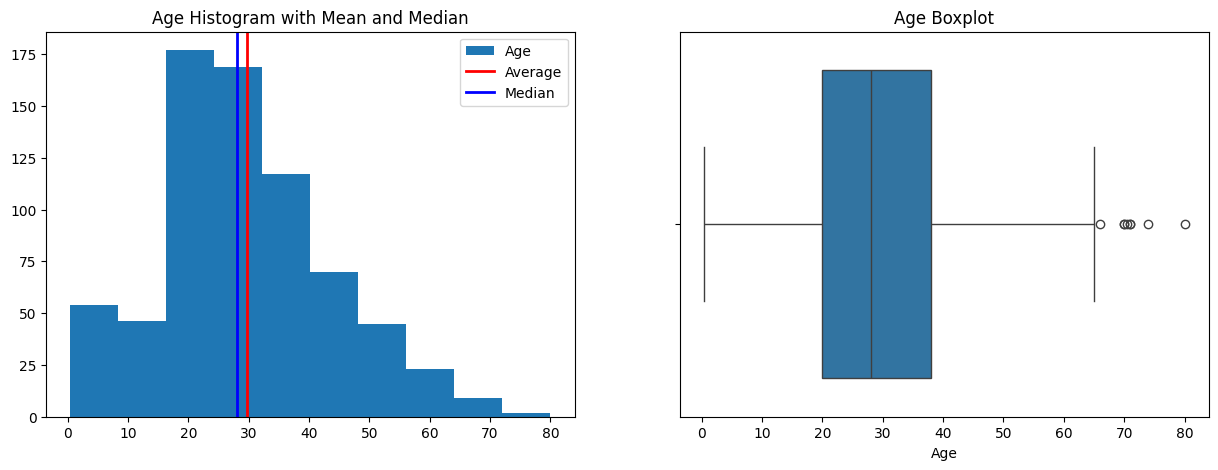

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of the 'Age' column
ax[0].hist(x='Age', data=train)
ax[0].axvline(np.mean(train['Age']), color='red', linestyle='solid', linewidth=2, label='Average')
ax[0].axvline(np.median(train[train['Age'].notnull()]['Age']), color='blue', linestyle='solid', linewidth=2, label='Median')
ax[0].legend()
ax[0].set_title('Age Histogram with Mean and Median')

# Boxplot of the 'Age' column
sns.boxplot(x="Age", data=train, ax=ax[1]).set_title('Age Boxplot')

plt.show()

<style>
  table {
    margin: auto;
    width: 50%;
    border-collapse: collapse; /* Para unir as bordas das células */
  }
  th, td {
    text-align: justify;
    padding: 8px;
    border: 1px solid black; /* Adiciona uma borda de 1px com cor cinza (#ddd) */
  }
</style>

<table>
    <tr>
        <th>  </th>
        <th> Age </th>
    </tr>
    <tr>
        <td>Population Size</td>
        <td>712.000</td>
    </tr>
    <tr>		
        <td>Mean</td>
        <td>29.642</td>
    </tr>
    <tr>		
        <td>Std. Deviation</td>
        <td>14.492</td>
    </tr>
    <tr>		
        <td>Min</td>
        <td>0.420</td>
    </tr>
    <tr>		
        <td>25% Qt</td>
        <td>20.000</td>
    </tr>
    <tr>		
        <td>Median</td>
        <td>28.000</td>
    </tr>
    <tr>		
        <td>75% Qt</td>
        <td>38.000</td>
    </tr>
    <tr>		
        <td>Max</td>
        <td>80.000</td>
    </tr>
</table>

Analyzing the graphs, the use of the **median** is preferable to replace missing age values, as it is a more robust measure in the presence of __outliers__.

In [79]:
# Median imputation
median_age = train[train['Age'].notnull()]['Age'].median()
train['Age'].fillna(median_age, inplace=True)
test['Age'].fillna(median_age, inplace=True)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Exploratory Data Analysis (EDA) 

After initial data cleaning, we will delve deeper into our dataset to discover **patterns** and  __identify relationships between variables__.

Let's start by exploring the initial composition of passengers.

In [80]:
# Summary of the dataset
train.describe(include ='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,889.000000,889.000000,889.000000,889,889.000000,889.000000,889.000000,889,889.000000,202,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,680,NaN,146,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.382452,2.311586,NaN,29.315152,0.524184,0.382452,NaN,32.096681,NaN,NaN
std,256.998173,0.486260,0.834700,NaN,12.984932,1.103705,0.806761,NaN,49.697504,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,224.000000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.000000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


On the whole, in the Titanic profile, passengers had an average age of 29, the average ticket at the time was 32.09, and the average socioeconomic status (SES) was 2 (Middle)

##### Analysis of the Embarked variable

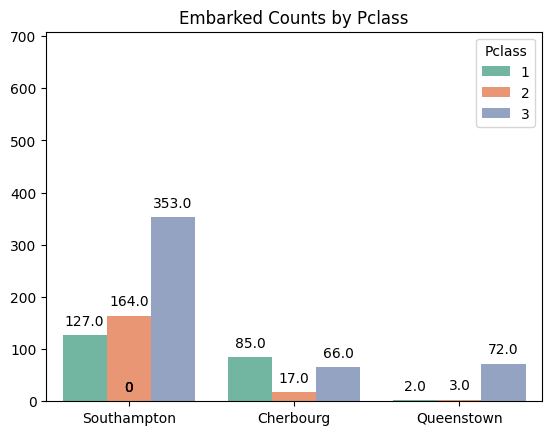

In [81]:
ax = sns.countplot(x='Embarked', hue='Pclass', data=train, palette='Set2')
ax.set_title('Embarked Counts by Pclass')
plt.xticks([0, 1, 2], ['Southampton', 'Cherbourg', 'Queenstown'])
plt.xlabel('')
plt.ylabel('')

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.ylim(0, train['Embarked'].value_counts().max() * 1.1) 
plt.show()

In the chart above, we can see that around 72% of passengers boarded at Southampton/IG, with 54% of them in third class. We can also see the average fare by boarding location and class.

In [82]:
print('Checking the average boarding fare by Pclass')
print()
print(pd.DataFrame({'Average Fare Embarked/Pclass': train.groupby(['Embarked', 'Pclass']).Fare.mean()}))

Checking the average boarding fare by Pclass

                 Average Fare Embarked/Pclass
Embarked Pclass                              
C        1                         104.718529
         2                          25.358335
         3                          11.214083
Q        1                          90.000000
         2                          12.350000
         3                          11.183393
S        1                          70.364862
         2                          20.327439
         3                          14.644083


It can be seen that the boarding location with the highest average fare was first class in Cherbourg and the lowest fare was third class in Queenstown.

### Feature Engineering

Here we will create new features or make transformations of existing features to improve the performance of a machine learning model.


An interesting fact is that the collision with the iceberg occurred on the starboard (right) side of the ship, near the bow (front). We can infer the proximity of the passenger's location from this information.

On the Titanic, cabins were organized by decks (A, B, C, etc.) and numbered to indicate their position on the ship. The location of the cabins on the decks determined whether they were on the starboard (right) side, port (left) side, or midship.

<div style="display: flex; justify-content: center;">
    <img src="https://www.titanicofficers.com/images/Titanic_F%20deck.jpg" alt="Título da Imagem" style="margin-right: 10px;">
    <img src="https://www.titanicofficers.com/images/Titanic_F%20deck_plan.jpg" alt="Título da Imagem">
</div>

Starboard side cabins usually followed the following naming pattern:

Deck + Number: The cabin number generally indicates its lateral position: 
- ``Even numbers:`` Typically indicate cabins on the port (left) side.  
- ``Odd numbers:`` Typically indicate cabins on the starboard (right) side.

URL: https://www.titanicofficers.com/titanic_06_boxhall_07.html

Based on the information above, we will create the __Starboard__ variable, which will identify the passengers positioned on the starboard side of the ship. To do this, we will consider all those with even cabin numbers, using the ``Cabin`` variable, which contains the cabin number of each passenger.

In [83]:
train["Cabin"] = train["Cabin"].fillna("")
test["Cabin"] = test["Cabin"].fillna("")
train["Starboard"] = train.apply(lambda row: 1 if (len(row["Cabin"]) > 0 and row["Cabin"][-1].isdigit() and int(row["Cabin"][-1]) % 2 != 0) else 0, axis=1)
test["Starboard"] = test.apply(lambda row: 1 if (len(row["Cabin"]) > 0 and row["Cabin"][-1].isdigit() and int(row["Cabin"][-1]) % 2 != 0) else 0,  axis=1)

train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,male,35.0,0,0,373450,8.0500,,S,0
5,6,0,3,male,28.0,0,0,330877,8.4583,,Q,0
6,7,0,1,male,54.0,0,0,17463,51.8625,E46,S,0
7,8,0,3,male,2.0,3,1,349909,21.0750,,S,0
8,9,1,3,female,27.0,0,2,347742,11.1333,,S,0
9,10,1,2,female,14.0,1,0,237736,30.0708,,C,0


Let's check if passengers sharing a ticket number with someone who was on the starboard side were also marked as starboard.

In [84]:
train[train['Ticket'].isin(train.loc[train['Starboard']==1, 'Ticket'])][lambda x: x['Starboard'] == 0]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard
258,259,1,1,female,35.0,0,0,PC 17755,512.3292,,C,0
325,326,1,1,female,36.0,0,0,PC 17760,135.6333,C32,C,0
373,374,0,1,male,22.0,0,0,PC 17760,135.6333,,C,0
380,381,1,1,female,42.0,0,0,PC 17757,227.5250,,C,0
533,534,1,3,female,28.0,0,2,2668,22.3583,,C,0
557,558,0,1,male,28.0,0,0,PC 17757,227.5250,,C,0
585,586,1,1,female,18.0,0,2,110413,79.6500,E68,S,0
700,701,1,1,female,18.0,1,0,PC 17757,227.5250,C62 C64,C,0
841,842,0,2,male,16.0,0,0,S.O./P.P. 3,10.5000,,S,0
856,857,1,1,female,45.0,1,1,36928,164.8667,,S,0


It's observed that some weren't marked as 'Starboard'. Let's correct that.

In [85]:
train["Starboard"] = train["Ticket"].isin(train.loc[train["Starboard"] == 1, "Ticket"]).astype(int)
test["Starboard"] = test["Ticket"].isin(test.loc[test["Starboard"] == 1, "Ticket"]).astype(int)

In [86]:
print('Checking the total count of rows classified as Starboard')
train.Starboard.value_counts()

Checking the total count of rows classified as Starboard


Starboard
0    789
1    100
Name: count, dtype: int64

Now, we will create the __Boat__ variable, which will indicate which deck the passenger was on. Decks are identified by letters (A, B, C, etc.), representing their level. To do this, we will again use the ``Cabin`` variable, which contains this information.

In [87]:
train['Boat'] = train['Cabin'].str[0] 
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,,S,0,NaN
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0,NaN
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,C
4,5,0,3,male,35.0,0,0,373450,8.0500,,S,0,NaN


In [88]:
print(pd.DataFrame({'Counts Boat': ['NOT NA', 'NA'], 'Values': [train['Boat'].notnull().sum(), train['Boat'].isnull().sum()], '% Values': [round(train['Boat'].notnull().sum() / train.shape[0] * 100, 2), round(train['Boat'].isnull().sum() / train.shape[0] * 100, 2)]}))

  Counts Boat  Values  % Values
0      NOT NA     202     22.72
1          NA     687     77.28


It is noticeable that many rows, specifically 687 (__77%__ of missing values), are missing information. For those with data, we will examine some metrics using the fare value (__Fare__) as a basis to infer the passenger profile for each deck level.

In [89]:
# Metrics
train[train['Boat'] != ''].groupby(['Embarked','Pclass','Boat']).agg({'Fare': ['count', 'sum', 'min', 'max', 'mean', 'median','var', 'std', lambda x: x.quantile(0.25),  # Q1
        lambda x: x.quantile(0.75),  # Q3
        lambda x: x.quantile(0.9)    # Q9
    ]
}).rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q3', '<lambda_2>': 'Q9'})

Fare                                            \
                     count        sum      min       max        mean   
Embarked Pclass Boat                                                   
C        1      A        7   268.5042  30.6958   56.9292   38.357743   
                B       22  3211.2084  27.7208  512.3292  145.964018   
                C       21  2070.2332  27.7500  227.5250   98.582533   
                D       11   941.4460  63.3583  113.2750   85.586000   
                E        5   464.5292  55.4417  134.5000   92.905840   
         2      D        2    26.6667  12.8750   13.7917   13.333350   
         3      F        1    22.3583  22.3583   22.3583   22.358300   
Q        1      C        2   180.0000  90.0000   90.0000   90.000000   
         2      E        1    12.3500  12.3500   12.3500   12.350000   
         3      F        1     7.7500   7.7500    7.7500    7.750000   
S        1      A        8   325.8541   0.0000   81.8583   40.731763   
                B       23  1963.5625   0.0000  211.3375   85.372283   
                C       36  3658.6959  26.5500  263.0000  101.630442   
                D       18   894.9583  25.9292   77.9583   49.719906   
                E       20   928.9750  25.5875   79.6500   46.448750   
                T        1    35.5000  35.5000   35.5000   35.500000   
         2      D        2    26.0000  13.0000   13.0000   13.000000   
                E        3    34.0000  10.5000   13.0000   11.333333   
                F        8   190.0000  10.5000   39.0000   23.750000   
         3      E        3    33.0000   8.0500   12.4750   11.000000   
                F        3    22.9500   7.6500    7.6500    7.650000   
                G        4    54.3250  10.4625   16.7000   13.581250   

                                                                     \
                        median           var         std         Q1   
Embarked Pclass Boat                                                  
C        1      A     35.50000     80.715016    8.984154  32.827100   
                B     79.20000  20000.093878  141.421688  58.979200   
                C     89.10420   3800.271331   61.646341  49.504200   
                D     76.72920    332.980274   18.247747  76.510450   
                E     83.15830   1563.260810   39.538093  56.929200   
         2      D     13.33335      0.420169    0.648205  13.104175   
         3      F     22.35830           NaN         NaN  22.358300   
Q        1      C     90.00000      0.000000    0.000000  90.000000   
         2      E     12.35000           NaN         NaN  12.350000   
         3      F      7.75000           NaN         NaN   7.750000   
S        1      A     42.75000    574.035041   23.959028  29.000000   
                B     86.50000   3905.645752   62.495166  42.750000   
                C     72.72500   5991.221719   77.402983  35.375000   
                D     52.20835    415.705360   20.388854  30.580200   
                E     52.48125    382.876594   19.567233  26.509375   
                T     35.50000           NaN         NaN  35.500000   
         2      D     13.00000      0.000000    0.000000  13.000000   
                E     10.50000      2.083333    1.443376  10.500000   
                F     26.00000    135.285714   11.631239  12.375000   
         3      E     12.47500      6.526875    2.554775  10.262500   
                F      7.65000      0.000000    0.000000   7.650000   
                G     13.58125     12.968802    3.601222  10.462500   

                                             
                              Q3         Q9  
Embarked Pclass Boat                         
C        1      A      39.862500   46.84668  
                B     222.270800  262.37500  
                C     110.883300  211.50000  
                D      95.770850  113.27500  
                E     134.500000  134.50000  
         2      D      13.562525   13.70003  
         3      F      22.35830

Based on the metrics above, we will construct intervals to classify the deck of passengers who do not have this information, using the fare paid. This approach will allow us to estimate passenger allocation in a more structured way.

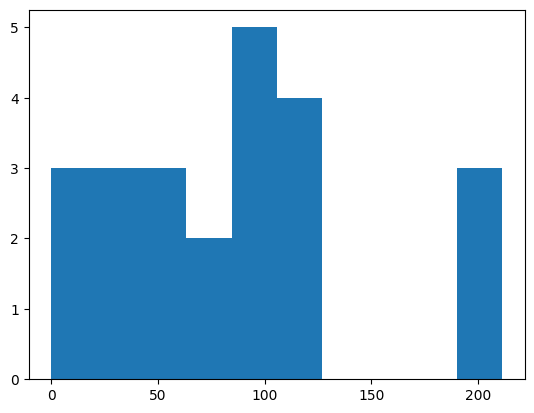

In [90]:
plt.hist(x=train[(train['Embarked'] == 'S') & (train['Pclass'] == 1) & (train['Boat'] == 'B')]['Fare'])
plt.show()

In [91]:
# Metric intervals using the fare paid
boat_intervals = {
'C': {1: {'A': (0, 30.6958), 
          'B': (30.6958, 56.9292),
          'C': (56.9292, 512.3292), 
          'E': (56.9292, 227.525)},
      2: {'D': (0, 42.0)},
      3: {'F': (4.0, 23.0)}
    },
'Q': {1: {'C': (0, 90)},
      2: {'E': (0, 12.35)},
      3: {'F': (6.0,  29.125)}
    },
'S': {1: {'A': (0, 26.55), 
          'T': (35.5, 35.5), 
          'B': (26.55, 81.8583),
          'C': (81.8583, 211.3375),
          'D': (211.3375, 263), 
          'E': (263, 79.65)},
      2: {'D': (0, 10.5),
          'E': (10.5, 13),
          'F': (13, 73.5)},
      3: {'E': (0, 12.475),
          'F': (12.475, 12.475),
          'G': (12.475, 69.55)}
    }
}

# Function that uses missing values
def assign_boat(row):
    if pd.isna(row['Boat']):
        intervals = boat_intervals.get(row['Embarked'], {}).get(row['Pclass'])
        if intervals:
            for boat, (min_fare, max_fare) in intervals.items():
                if min_fare <= row['Fare'] <= max_fare:
                    return boat
    return row['Boat']


# Apply the function to update missing values
train['Boat'] = train.apply(assign_boat, axis=1)
test['Boat'] = train.apply(assign_boat, axis=1)

# Exibir os dados atualizados
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,,S,0,E
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0,E
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,C
4,5,0,3,male,35.0,0,0,373450,8.0500,,S,0,E


In [92]:
print('Checking whether all missing values ​​were properly classified in their respective decks.')
print(pd.DataFrame({'Counts Boat': ['NOT NA', 'NA'], 'Values': [train['Boat'].notnull().sum(), train['Boat'].isnull().sum()]}))

Checking whether all missing values ​​were properly classified in their respective decks.
  Counts Boat  Values
0      NOT NA     889
1          NA       0


In [93]:
print('Checking the distribution of passengers by Boat')
print(pd.DataFrame({'Counts': train.Boat.value_counts(), '% Counts': round(train.Boat.value_counts()/train.shape[0]*100,2)}))

Checking the distribution of passengers by Boat
      Counts  % Counts
Boat                  
E        316     35.55
F        229     25.76
G        110     12.37
C         74      8.32
D         74      8.32
B         55      6.19
A         30      3.37
T          1      0.11


It's observed that a large portion of the Titanic's passengers were on decks __E__ and __F__, representing over __60%__ of the total.

Finally, we will create the variable __Age Class__, which will classify passengers according to age in the following categories: 1 - Child, 2 - Young, 3 - Adult and 4 - Elderly.

In [94]:
# Age Class 
train["Age_Class"] = train.apply(lambda row: 1 if row['Age'] <= 12 else 2 if row['Age'] <= 18 else 3 if row['Age'] <= 59 else 4, axis=1)
test["Age_Class"] = test.apply(lambda row: 1 if row['Age'] <= 12 else 2 if row['Age'] <= 18 else 3 if row['Age'] <= 59 else 4, axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat,Age_Class
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,,S,0,E,3
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,3
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0,E,3
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,C,3
4,5,0,3,male,35.0,0,0,373450,8.0500,,S,0,E,3


In [95]:
print('Checking the distribution of passengers by Age Class')
print(pd.DataFrame({'Counts': train.Age_Class.value_counts(), '% Counts': round(train.Age_Class.value_counts()/train.shape[0]*100,2)}))

Checking the distribution of passengers by Age Class
           Counts  % Counts
Age_Class                  
3             725     81.55
2              70      7.87
1              69      7.76
4              25      2.81


From the above distribution of __Age Class__ we conclude that the Titanic passengers were mostly Adults.

Now we will make some changes to the variables in our dataset in order to improve the model's performance and ensure that it interprets the data correctly. We will use __Label Encoding__, which is a technique for converting categorical variables into numeric values. It assigns an integer to each category, making the data usable by machine learning algorithms that require numeric input.

##### Label encoded

First, let’s change the type of the variables ``Sex``, ``Embarked``, ``Boat`` to categorical.

In [96]:
# Convert the variables Sex, Embarked and Boat to the categorical type.
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

train['Embarked'] = train['Embarked'].astype('category')
test['Embarked'] = test['Embarked'].astype('category')

train['Boat'] = train['Boat'].astype('category')
test['Boat'] = test['Boat'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  889 non-null    int64   
 1   Survived     889 non-null    int64   
 2   Pclass       889 non-null    int64   
 3   Sex          889 non-null    category
 4   Age          889 non-null    float64 
 5   SibSp        889 non-null    int64   
 6   Parch        889 non-null    int64   
 7   Ticket       889 non-null    object  
 8   Fare         889 non-null    float64 
 9   Cabin        889 non-null    object  
 10  Embarked     889 non-null    category
 11  Starboard    889 non-null    int32   
 12  Boat         889 non-null    category
 13  Age_Class    889 non-null    int64   
dtypes: category(3), float64(2), int32(1), int64(6), object(2)
memory usage: 115.4+ KB


In [67]:
# Não roda isso 
# Assigning numerical values and storing it in another columns 
train['Sex_new'] = train['Sex'].cat.codes 
train['faixa_age_new'] = train['faixa_age'].cat.codes 
  
# Create an instance of One-hot-encoder 
enc = OneHotEncoder() 
  
# Passing encoded columns 
enc_data = pd.DataFrame(enc.fit_transform(train[['Sex_new', 'faixa_age_new']]).toarray()) 

# Merge with main 
train = train.join(enc_data)

KeyError: 'faixa_age'

In [97]:
# LabelEncoder

# Convert categorical variables to a numeric format
label_encoder = LabelEncoder()
train['Sex'] = label_encoder.fit_transform(train['Sex'])
test['Sex'] = label_encoder.fit_transform(test['Sex'])

train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
test['Embarked'] = label_encoder.fit_transform(test['Embarked'])

train['Boat'] = label_encoder.fit_transform(train['Boat'])
test['Boat'] = label_encoder.fit_transform(test['Boat'])
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat,Age_Class
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,,2,0,4,3
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,0,1,2,3
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,,2,0,4,3
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,2,1,2,3
4,5,0,3,1,35.0,0,0,373450,8.0500,,2,0,4,3


The ``Age`` and ``Fare`` columns have different scales. Normalization or scaling is recommended for this type of situation, as variables with __different scales can negatively impact the performance__ of the machine learning model. We will use the __MinMaxScaler__ technique, which is best suited for classification problems.

##### MinMaxScaler

In [98]:
# MinMaxScaler
scaler = MinMaxScaler()
train[['Age', 'Fare']] = scaler.fit_transform(train[['Age', 'Fare']])
test[['Age', 'Fare']] = scaler.fit_transform(test[['Age', 'Fare']])

train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat,Age_Class
0,1,0,3,1,0.271174,1,0,A/5 21171,0.014151,,2,0,4,3
1,2,1,1,0,0.472229,1,0,PC 17599,0.139136,C85,0,1,2,3
2,3,1,3,0,0.321438,0,0,STON/O2. 3101282,0.015469,,2,0,4,3
3,4,1,1,0,0.434531,1,0,113803,0.103644,C123,2,1,2,3
4,5,0,3,1,0.434531,0,0,373450,0.015713,,2,0,4,3


##### Correlation Matrix

To check how the variables are __correlated__ with our target variable, we can create a correlation matrix. This matrix, which consists of a table that presents the correlation coefficients between several variables, will be a valuable tool for evaluating the relationships between them and the target variable.

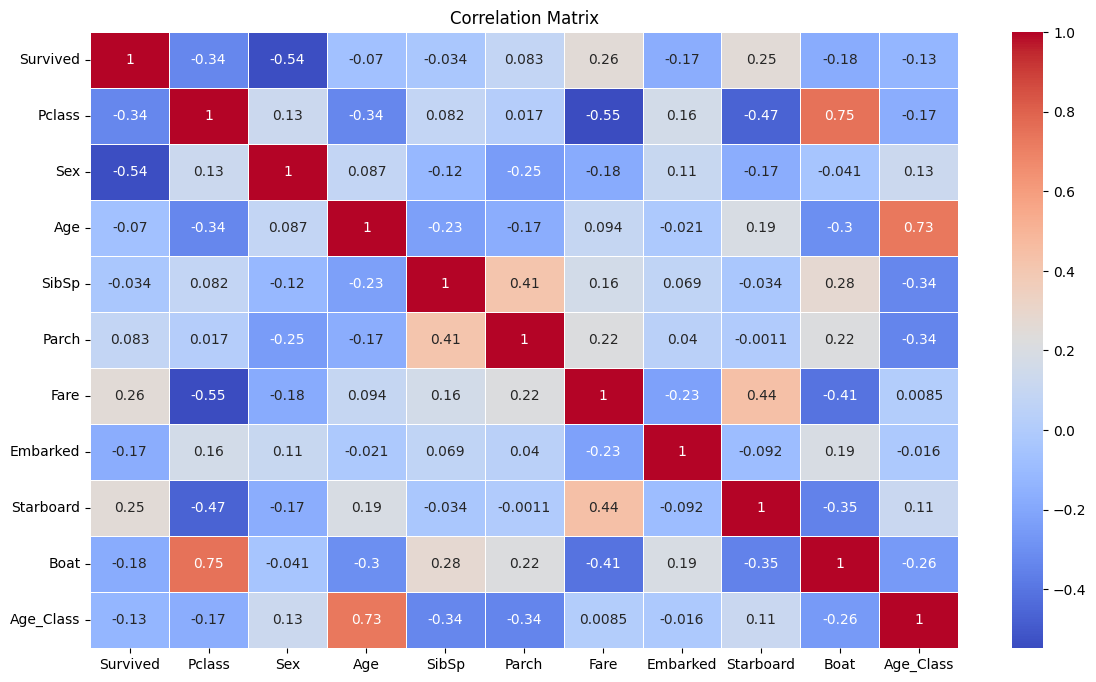

In [108]:
# Correlation Matrix
matrix_corr = train.drop(columns=['PassengerId', 'Ticket', 'Cabin']).corr()

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can observe that the features __Pclass, Sex, Age, SibSp, Embarked, Boat, Age_class__ are inversely proportional to the variable ``Survived``. The features __Parch, Fare, Starboard__ are proportional to the variable ``Survived``.

In [ ]:
one_hot_encoded_data_test = one_hot_encoded_data_test[['Sex_female', 'Sex_male', 'Pclass', 'Age', 'faixa_age', 'Fare']]
one_hot_encoded_data_test.head()

Correlation indicates the degree of linear relationship between two variables, but not necessarily their predictive power in a model. To quantify the importance of a variable in predicting survival (or another target variable), we can calculate the __Information Gain__. This metric evaluates the statistical dependence between features and the target, identifying which attributes have the greatest influence on the classification.

##### Information Gain

In [119]:
X = train[['Pclass', 'Sex',  'Age', 'Fare', 'Embarked', 'Starboard' ,'Boat', 'Age_Class', 'SibSp', 'Parch']]
y = train.Survived

IG = mutual_info_classif(X, y, discrete_features="auto", random_state=1)

# Create a DataFrame with the results
result = pd.DataFrame({"Features": X.columns, "Information Gain": IG})
result = result.sort_values(by="Information Gain", ascending=False)

print(result)

    Features  Information Gain
1        Sex          0.161937
3       Fare          0.134439
0     Pclass          0.076892
6       Boat          0.044093
5  Starboard          0.032780
7  Age_Class          0.020762
8      SibSp          0.017452
4   Embarked          0.015978
2        Age          0.015923
9      Parch          0.015133


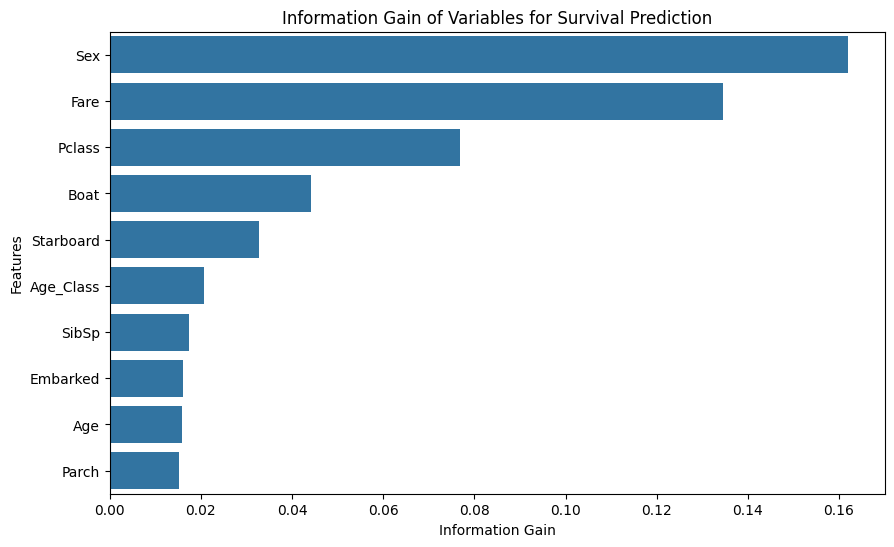

In [121]:
# Information Gain Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="Information Gain", y="Features", data=result)
plt.xlabel("Information Gain")
plt.ylabel("Features")
plt.title("Information Gain of Variables for Survival Prediction")
plt.show()

We can see that the most relevant features (__Highest Impact__) were ``Sex``, indicating that sex is the most determining factor, followed by ``Fare`` and ``Pclass`` — passengers with higher fares or in higher classes (Pclass = 1) had a greater chance of survival. The ``Boat`` and ``Starboard`` features also stand out, revealing interesting patterns:
Boat (passenger deck):
- Location on the ship (decks A, B, C, etc.) had a significant impact on survival, as upper decks (such as A) were closer to the lifeboats and, therefore, prioritized during the rescue.

Starboard (starboard side of the ship):
- Passengers with even-numbered cabins (starboard side) had a higher survival rate, possibly due to the asymmetric distribution of lifeboats or evacuation routes during the sinking.

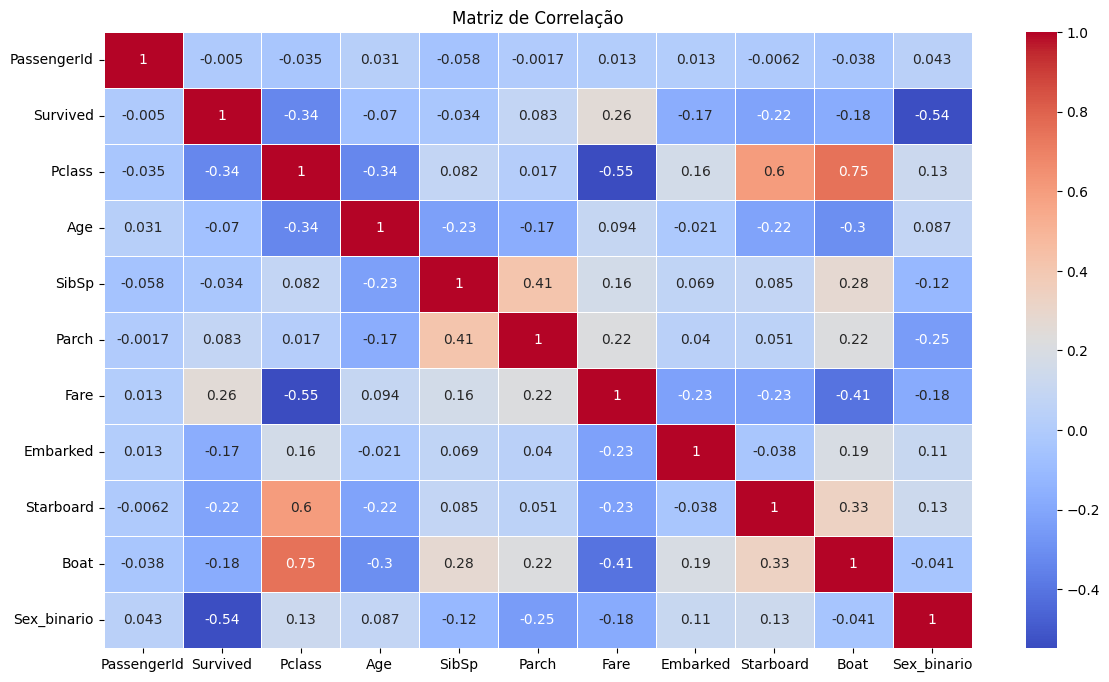

In [51]:
matrix_corr = train.drop(columns=['Sex', 'Ticket', 'Cabin']).corr()

plt.figure(figsize=(14, 8))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
train.info()

In [69]:
X = train[['Pclass', 'Sex',  'Age', 'Fare', 'Embarked', 'Starboard' ,'Boat', 'Age_Class', 'SibSp', 'Parch']]
y = train.Survived

#### Modeling 

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=1) # 0.5 é usado pq o dataset é muito pequeno 

In [71]:
mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
mod.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [72]:
X_prev = mod.predict(X_valid)
X_prev, X_prev.shape

(array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 

In [73]:
np.mean(y_valid == X_prev)

0.8247191011235955

In [74]:
np.mean(resultados)

0.7997656645409454

In [75]:
# METODO DE REAMOSTRAM 
# RepeatedKFold
resultados = []

kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1)
for line_train, line_valid in kf.split(X):
    print('Treino: ', line_train.shape[0])
    print('Valid: ', line_valid.shape[0])

    X_train, X_valid = X.iloc[line_train], X.iloc[line_valid]
    y_train, y_valid = y.iloc[line_train], y.iloc[line_valid]


    mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
    #mod = LogisticRegression()
    mod.fit(X_train, y_train)


    X_prev = mod.predict(X_valid)
    acc = np.mean(y_valid == X_prev)
    resultados.append(acc)
    print('Acc:', acc)
    print()

Treino:  444
Valid:  445
Acc: 0.8112359550561797

Treino:  445
Valid:  444
Acc: 0.7995495495495496

Treino:  444
Valid:  445
Acc: 0.8157303370786517

Treino:  445
Valid:  444
Acc: 0.786036036036036

Treino:  444
Valid:  445
Acc: 0.7865168539325843

Treino:  445
Valid:  444
Acc: 0.8063063063063063

Treino:  444
Valid:  445
Acc: 0.8247191011235955

Treino:  445
Valid:  444
Acc: 0.8018018018018018

Treino:  444
Valid:  445
Acc: 0.8337078651685393

Treino:  445
Valid:  444
Acc: 0.8108108108108109

Treino:  444
Valid:  445
Acc: 0.8134831460674158

Treino:  445
Valid:  444
Acc: 0.8085585585585585

Treino:  444
Valid:  445
Acc: 0.8224719101123595

Treino:  445
Valid:  444
Acc: 0.7905405405405406

Treino:  444
Valid:  445
Acc: 0.8134831460674158

Treino:  445
Valid:  444
Acc: 0.8018018018018018

Treino:  444
Valid:  445
Acc: 0.7685393258426966

Treino:  445
Valid:  444
Acc: 0.8018018018018018

Treino:  444
Valid:  445
Acc: 0.8

Treino:  445
Valid:  444
Acc: 0.8018018018018018



In [76]:
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\maylon\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(array([1., 0., 2., 1., 2., 5., 5., 1., 2., 1.]),
 array([0.76853933, 0.77505618, 0.78157303, 0.78808989, 0.79460674,
        0.8011236 , 0.80764045, 0.8141573 , 0.82067416, 0.82719101,
        0.83370787]),
 <BarContainer object of 10 artists>)

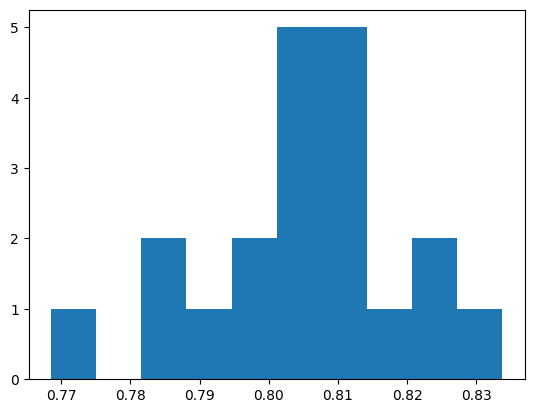

In [77]:
pylab.hist(resultados)

In [134]:
## Analise de Erro
X_valid_check = train.iloc[line_valid].copy()
X_valid_check['X_prev'] = X_prev
X_valid_check.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Starboard,Boat,Age_Class,Sex_binario,X_prev
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,,2,0,4,3,1,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,,2,0,4,3,0,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,2,1,2,3,0,1
5,6,0,3,male,28.0,0,0,330877,8.4583,,1,0,5,3,1,0
6,7,0,1,male,54.0,0,0,17463,51.8625,E46,2,0,4,3,1,0


In [168]:
X_valid_check.shape

(444, 16)

In [136]:
erros = X_valid_check[X_valid_check['Survived'] != X_valid_check['X_prev']]
erros = erros[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'faixa_age', 'Sex_binario', 'Survived', 'X_prev']] # so ordenou para que as colunas Survived e X_orev fiquem lado a lado
erros.head()

KeyError: "['faixa_age'] not in index"

In [35]:
# Agora é a parte subjetiva, é a parte que voce usa o conhecimento dos dados, do processo que gerou esses dados, o conhecimento de machine learning para tentar melhorar esse modelo 

mulheres = erros[erros['Sex_binario'] == 0]
homens = erros[erros['Sex_binario'] == 1]

In [ ]:
mulheres.sort_values('Survived')

In [ ]:
homens.sort_values('Survived')

In [169]:
# metodo de reamostragem
# validação cruzada 

resultados = []
for i in range(10):
    print('Rep:', i)
    kf = KFold(2, shuffle=True, random_state=i)
    for line_train, line_valid in kf.split(X):
        print('Treino: ', line_train.shape[0])
        print('Valid: ', line_valid.shape[0])

        X_train, X_valid = X.iloc[line_train], X.iloc[line_valid]
        y_train, y_valid = y.iloc[line_train], y.iloc[line_valid]


        mod = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
        mod.fit(X_train, y_train)


        X_prev = mod.predict(X_valid)
        acc = np.mean(y_valid == X_prev)
        resultados.append(acc)
        print('Acc:', acc)
        print()

Rep: 0
Treino:  444
Valid:  445
Acc: 0.8089887640449438

Treino:  445
Valid:  444
Acc: 0.8175675675675675

Rep: 1
Treino:  444
Valid:  445
Acc: 0.8179775280898877

Treino:  445
Valid:  444
Acc: 0.7995495495495496

Rep: 2
Treino:  444
Valid:  445
Acc: 0.7865168539325843

Treino:  445
Valid:  444
Acc: 0.795045045045045

Rep: 3
Treino:  444
Valid:  445
Acc: 0.7865168539325843

Treino:  445
Valid:  444
Acc: 0.8288288288288288

Rep: 4
Treino:  444
Valid:  445
Acc: 0.8112359550561797

Treino:  445
Valid:  444
Acc: 0.7792792792792793

Rep: 5
Treino:  444
Valid:  445
Acc: 0.8269662921348314

Treino:  445
Valid:  444
Acc: 0.7702702702702703

Rep: 6
Treino:  444
Valid:  445
Acc: 0.8067415730337079

Treino:  445
Valid:  444
Acc: 0.8085585585585585

Rep: 7
Treino:  444
Valid:  445
Acc: 0.8134831460674158

Treino:  445
Valid:  444
Acc: 0.8130630630630631

Rep: 8
Treino:  444
Valid:  445
Acc: 0.7932584269662921

Treino:  445
Valid:  444
Acc: 0.8378378378378378

Rep: 9
Treino:  444
Valid:  445
Acc: 0

In [170]:
resultados

[0.8089887640449438,
 0.8175675675675675,
 0.8179775280898877,
 0.7995495495495496,
 0.7865168539325843,
 0.795045045045045,
 0.7865168539325843,
 0.8288288288288288,
 0.8112359550561797,
 0.7792792792792793,
 0.8269662921348314,
 0.7702702702702703,
 0.8067415730337079,
 0.8085585585585585,
 0.8134831460674158,
 0.8130630630630631,
 0.7932584269662921,
 0.8378378378378378,
 0.7910112359550562,
 0.8063063063063063]

In [ ]:
np.mean(resultados)

0.8049501467759894

In [ ]:
with open('gender_submission1.csv', 'w', newline='') as prediction:
    fields = ['PassengerId', 'Survived']
    prediction_writer = csv.DictWriter(prediction, fieldnames=fields)
    prediction_writer.writeheader()
    for passenger_id, survived in pd.Series(X_prev, index=test['PassengerId']).items():
        prediction_writer.writerow({'PassengerId': passenger_id, 'Survived': survived})
